# Analizar UCI census dataset.

In [1]:
import re
import numpy as np
import pandas as pd
eps = np.finfo(float).eps
from numpy import log2 as log
from tabulate import tabulate as tb
from anytree import Node, RenderTree
from anytree import search as anys
from anytree.exporter import DotExporter
from IPython.display import Image
from IPython.display import Markdown
import time

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


##### Load dataset:

In [2]:
features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status",
            "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
            "Hours per week", "Country", "Target"]
train_data = pd.read_csv(
    #"https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    "adult.data",
    names=features,
    sep=r'\s*,\s*',
    engine='python',
    na_values="?").dropna()

Target = 'Target'
Labels = train_data.Target.unique()
counts = train_data.Target.value_counts()
print(counts)

test_data = pd.read_csv(
    #"https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    "adult.test_fix",
    names=features,
    sep=r'\s*,\s*',
    skiprows=[0],
    engine='python',
    na_values="?").dropna()

Labels = test_data.Target.unique()
counts = test_data.Target.value_counts()
print(counts)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


<=50K    22654
>50K      7508
Name: Target, dtype: int64
<=50K    11360
>50K      3700
Name: Target, dtype: int64


In [3]:
train_data.head(5)

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Escolher uma coluna para fazer a predição. Qual?
##### Impurity functions:

- **Gini index** [Gini, 1912]:

$ i_G(t) = \sum\limits_{k \forall \Omega} p_{kt}(1 - p_{kt}) $

- **Shannon entropy** [Shannon and Waver, 1949]:

$ i_H(t) = \sum\limits_{k \forall \Omega} |p_{kt}\log_2(p_{kt})| $

With the set of classes $\Omega$ and the probability of $k$-classe given node $t$: $p_{kt} \triangleq p(c_k|t) ~|~ p(c_k|t) \in [0, 1]$.
Obs.: some authors uses $S$ (common symbol) to denote *entropy*, here we use $i$ (impurity).
Obs. 2: see Figure 3.1 and 3.3 in Louppe [2014] for a better view of a decision tree structure.

- **Fcuntion defined**:

$ i_T(t) = \sum\limits_{k \forall \Omega} f_T(p_{kt}) $

$f_T(x) =  \begin{cases} 
      x(1-x) & T = \text{Gini} \\
      |x\log_2(x)| & T = \text{Shannon} \\
   \end{cases} $

Were $T$ is the type of impurity (Gini or Shannon).


## Calcula a entropia total (considerando o dataset/batch inteiro)

In [4]:
def find_entropy(df):
    entropy = 0
    values = df[Target].unique()
    for value in values:
        temp = df[Target].value_counts()[value]/len(df[Target])
        entropy += -temp*np.log2(temp)
    return entropy

In [5]:
Markdown("## {}".format(find_entropy(train_data)))

## 0.8095658329614157

## Cacula a entropia considerando cada coluna ($feature$)

In [6]:
def find_entropy_attribute(df,attribute):
    
    if not np.issubdtype(df[attribute].dtype, np.number):   
        return find_entropy_attribute_not_number(df,attribute), None
    else:
        return find_entropy_attribute_number(df,attribute)
                 
def find_entropy_attribute_not_number(df,attribute):
    target_variables = df[Target].unique()  #This gives all 'Yes' and 'No'
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    entropy2 = 0
    for variable in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]==variable][df[Target] ==target_variable])
            den = len(df[attribute][df[attribute]==variable])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        entropy2 += -(den/len(df))*entropy
    return abs(entropy2)


def find_entropy_attribute_number(df,attribute):
    target_variables = df[Target].unique()  #This gives all 'Yes' and 'No'
    variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
    variables.sort()
    if len(variables)>2:
        variables = variables[1:-1]
        vk3 = variables[0]
        entropy3 = 0
    else:
        vk3 = variables[0]
        entropy3 = np.Inf
    
    for vk in variables:
        entropy = 0
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]<=vk][df[Target] ==target_variable])
            den = len(df[attribute][df[attribute]<=vk])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        for target_variable in target_variables:
            num = len(df[attribute][df[attribute]>vk][df[Target] ==target_variable])
            den = len(df[attribute][df[attribute]>vk])
            fraction = num/(den+eps)
            entropy += -fraction*log(fraction+eps)
        entropy2 = (den/len(df))*abs(entropy)
        #print(str(entropy2)+"|"+str(vk))
        if entropy2>entropy3:
            entropy3 = entropy2
            vk3 = vk
    return abs(entropy3),vk3


In [7]:
train_data.columns.difference([Target])

Index(['Age', 'Capital Gain', 'Capital Loss', 'Country', 'Education',
       'Education-Num', 'Hours per week', 'Marital Status', 'Occupation',
       'Race', 'Relationship', 'Sex', 'Workclass', 'fnlwgt'],
      dtype='object')

In [8]:
Markdown("## Age: {} <br/><br/> Sex: {} <br/><br/> Education: {} <br/><br/> Relationship: {} <br/><br/> Capital Gain: {} <br/><br/> Capital Loss: {} <br/><br/>".format(
    find_entropy_attribute(train_data,'Age'),
    find_entropy_attribute(train_data,'Sex'),
    find_entropy_attribute(train_data,'Education'),
    find_entropy_attribute(train_data,'Relationship'),
    find_entropy_attribute(train_data,'Capital Gain'),
    find_entropy_attribute(train_data,'Capital Loss')))

## Age: (0.8724683204621753, 30) <br/><br/> Sex: (0.7721594258316462, None) <br/><br/> Education: (0.7161718474840457, None) <br/><br/> Relationship: (0.6433875153507733, None) <br/><br/> Capital Gain: (0.1426919229558913, 114) <br/><br/> Capital Loss: (0.08447998313818121, 155) <br/><br/>

## Função para selecionar a features ótima.

In [9]:
def find_winner(df,rfs_par=False):
    if not rfs_par:
        IG = []
        vk = list()
        for key in df.columns.difference([Target]):
            temp,temp2 = find_entropy_attribute(df,key)
            vk.append(temp2)
            IG.append(find_entropy(df)-temp)
        return df.columns.difference([Target])[np.argmax(IG)], vk[np.argmax(IG)]
    else:
        key = df.columns.difference([Target])[np.random.randint(len(df.columns.difference([Target]))-1)]
        temp,vk = find_entropy_attribute(df,key)
        return key, vk

In [10]:
temp = find_winner(train_data)

In [11]:
Markdown("## Melhor $feature$: {} <br/><br/> ".format(temp))

## Melhor $feature$: ('Capital Loss', 155) <br/><br/> 

## Separa a base em duas 'Capital Loss' > 155 e <= 155


## Se fosse 'Sex'? 
## Duas bases com 'Sex' = Male e outra com 'Sex' = Female

## Para cada base, repete o processo com algum critério de parada.
<br><br><br>

## Funções para contruir e mostrar uma árvore dicisória.

### Constrói uma árvore:

In [12]:
def buildtree(df,tree=None, mytree=None, T_pro=0.9, T_pro_num=0.6,total_splits=10,splits=1):
    
    def ramificatree(Thd,ss):
        if (len(clValue)==1):
            tree[node][value] = {}
            tree[node][value]['Class'] = clValue[0]
            tree[node][value]['Prob'] = 1.0
            #print_result_node(node,value,clValue[0],1)
        else:
            prob = counts.max() / counts.sum()
            if (prob>=Thd)or(splits>=total_splits):
                tree[node][value] = {}
                tree[node][value]['Class'] = clValue[counts.argmax()]
                tree[node][value]['Prob'] = prob
                #print_result_node(node,value,clValue[counts.argmax()],prob)
            else:
                ss += 1
                tree[node][value] = buildtree(subtable,splits=ss)
                #print(node +' : '+value+' : *')

    #print(find_winner(df))
    #formata_dados(dados)
    node,vk = find_winner(df)

    if tree is None:
        tree={}
        tree[node] = {}

    if vk is None:
        attValue = np.unique(df[node])
        for value in attValue:

            subtable = df[df[node] == value].reset_index(drop=True)
            clValue,counts = np.unique(subtable[Target],return_counts=True)

            splits += 1
            ramificatree(T_pro,ss=splits)
    else:
        
        if (len(df[node][df[node] <= vk].unique())>0) and (len(df[node][df[node] > vk].unique())>0):
           
            # >vk
            value = node+' >'+str(vk)
            subtable = df[df[node] > vk].rename(columns = {node:value}).reset_index(drop=True)
            clValue,counts = np.unique(subtable[Target],return_counts=True)            
            if (len(subtable[value].unique())==1) and (len(clValue)>1):
                tree[node][value] = {}
                tree[node][value]['Class'] = clValue[counts.argmax()]
                prob = counts.max() / counts.sum()
                tree[node][value]['Prob'] = prob
                #print_result_node(node,value,clValue[counts.argmax()],prob)
            else:
                splits += 1
                ramificatree(T_pro_num,ss=splits)
            clValue_antes = clValue[0]
            value_antes = value
            # <=vk
            value = node+' <='+str(vk)
            subtable = df[df[node] <= vk].rename(columns = {node:value}).reset_index(drop=True)
            clValue,counts = np.unique(subtable[Target],return_counts=True)
            if ((len(subtable[value].unique())==1) and (len(clValue)>1)):
                tree[node][value] = {}
                tree[node][value]['Class'] = clValue[counts.argmax()]
                prob = counts.max() / counts.sum()
                tree[node][value]['Prob'] = prob
                #print_result_node(node,value,clValue[counts.argmax()],prob)
            else:
                splits += 1
                ramificatree(T_pro_num,ss=splits)

        else:
            df[node] = df[node].astype(str)
            buildtree(df)
        
    return tree

In [13]:
t = time.process_time()
tree =  buildtree(train_data)
elapsed_time1 = time.process_time() - t

In [14]:
Markdown("## Tempo (s): {:.2f} <br/><br/> ".format(elapsed_time1))

## Tempo (s): 468.56 <br/><br/> 

In [15]:
tree

{'Capital Loss': {'Capital Loss <=155': {'Class': '<=50K',
   'Prob': 0.7643722160356348},
  'Capital Loss >155': {'Relationship': {'Husband': {'Education': {'10th': {'Hours per week': {'Hours per week <=47': {'Class': '>50K',
         'Prob': 0.8571428571428571},
        'Hours per week >47': {'Class': '<=50K', 'Prob': 1.0}}},
      '11th': {'Hours per week': {'Hours per week <=40': {'Class': '<=50K',
         'Prob': 0.8},
        'Hours per week >40': {'Class': '>50K', 'Prob': 0.6666666666666666}}},
      '12th': {'Capital Loss >155': {'Capital Loss >155 <=1651': {'Class': '<=50K',
         'Prob': 1.0},
        'Capital Loss >155 >1651': {'Class': '>50K', 'Prob': 1.0}}},
      '1st-4th': {'Class': '<=50K', 'Prob': 1.0},
      '5th-6th': {'Class': '<=50K', 'Prob': 0.8571428571428571},
      '7th-8th': {'Class': '<=50K', 'Prob': 0.9166666666666666},
      '9th': {'Class': '<=50K', 'Prob': 0.6666666666666666},
      'Assoc-acdm': {'Class': '>50K', 'Prob': 0.6428571428571429},
      'A

### Funções para mostrar a árvore.

In [16]:
def print_tree(arg):
    for pre, fill, node in RenderTree(arg):
        print("%s%s" % (pre, node.name))
        
def converte_para_anytree(tree,node=None,mytree=None):
    
    if node is None:
        temp = list(tree.keys())
        node = temp[0]
        mytree = {}
        mytree[node] = Node(node)
        converte_para_anytree(tree,node,mytree)
    else:
        tree = tree[node]
        if not isinstance(tree, str):
            childs = list(tree.keys())
            for child in childs:
                if (list(tree[child])[0] == 'Class'):
                    temp = mytree[node]
                    mytree[child] = Node(child, parent=temp, target=tree[child]['Class'], prob=tree[child]['Prob'])
                else:
                    temp = mytree[node]
                    mytree[child] = Node(child, parent=temp)
                    converte_para_anytree(tree,child,mytree)
        else:
            mytree[node] = 'Fim'
                
    return mytree

#anys.findall_by_attr(mytree['Taste'], name="target", value='Yes')

def mostra_tree(tree):
    mytree = converte_para_anytree(tree)

    temp = list(tree.keys())
    root = temp[0]
    mytree[root]

    for pre, fill, node in RenderTree(mytree[root]):
        txt_node = str(node)
        m = re.search('prob\=\d+\.\d+', txt_node)
        if  Labels[0] in txt_node:
            if not m is None:
                print("%s%s" % (pre, node.name+': '+Labels[0]+' ('+m.group()[5:]+')'))
            else:
                print("%s%s" % (pre, node.name+': '+Labels[0]+' (?)'))
        elif Labels[1] in txt_node:
            if not m is None:
                print("%s%s" % (pre, node.name+': '+Labels[1]+' ('+m.group()[5:]+')'))
            else:
                print("%s%s" % (pre, node.name+': '+Labels[1]+' (?)'))
        else:
            print("%s%s" % (pre, node.name))
    
    
def mostra_tree_graph(tree, largura=None, altura=None):
    mytree = converte_para_anytree(tree)

    temp = list(tree.keys())
    root = temp[0]
    mytree[root]
    DotExporter(mytree[root]).to_picture("tree.png")
    return Image(filename='tree.png', width=largura, height=altura) 


In [17]:
 mostra_tree(tree)

Capital Loss
├── Capital Loss >155
│   └── Relationship
│       ├── Husband
│       │   └── Education
│       │       ├── 10th
│       │       │   └── Hours per week
│       │       │       ├── Hours per week >47: <=50K (1.0)
│       │       │       └── Hours per week <=47: >50K (0.8571428571428571)
│       │       ├── 11th
│       │       │   └── Hours per week
│       │       │       ├── Hours per week >40: >50K (0.6666666666666666)
│       │       │       └── Hours per week <=40: <=50K (0.8)
│       │       ├── 12th
│       │       │   └── Capital Loss >155
│       │       │       ├── Capital Loss >155 >1651: >50K (1.0)
│       │       │       └── Capital Loss >155 <=1651: <=50K (1.0)
│       │       ├── 1st-4th: <=50K (1.0)
│       │       ├── 5th-6th: <=50K (0.8571428571428571)
│       │       ├── 7th-8th: <=50K (0.9166666666666666)
│       │       ├── 9th: <=50K (0.6666666666666666)
│       │       ├── Assoc-acdm: >50K (0.6428571428571429)
│       │       ├── Assoc-voc: >50K (0.5

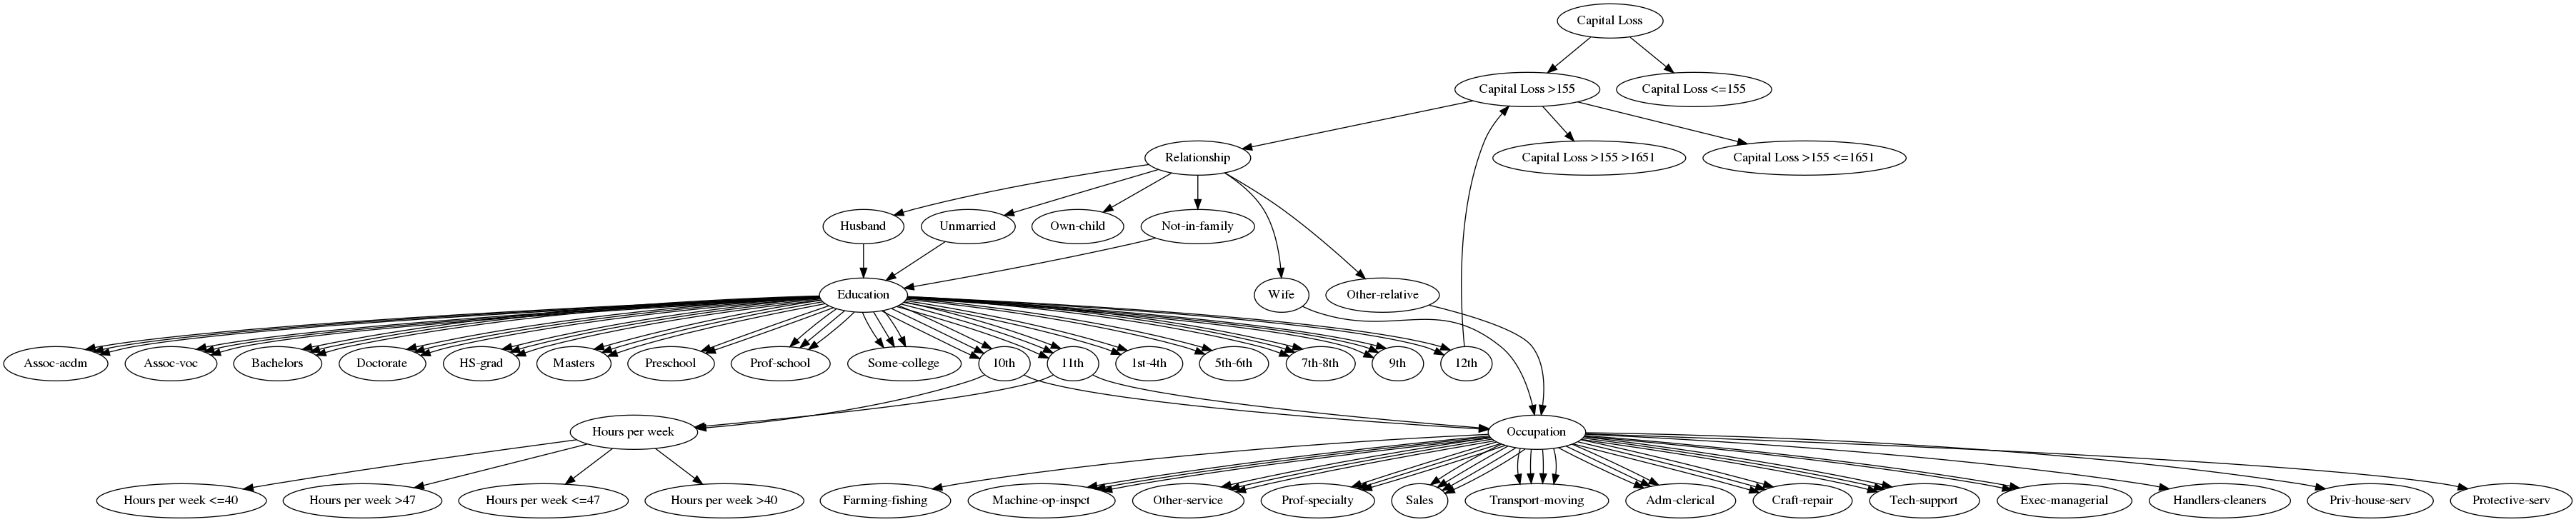

In [18]:
 mostra_tree_graph(tree)

## Fazendo uma predição

In [19]:
def predict(inst,tree):

    for node in tree.keys():     

        if ('<=' in str(tree[node].keys())):

            childs = list(tree[node].keys())

            if ('<=' in childs[1]):
                temp = childs[1]
                childs[1] = childs[0]
                childs[0] = temp

            vk = float(childs[1].split('>')[1])
            
            if ('>' in node):
                valor = float(str(inst[node.split('>')[0][:-1]]))
            elif ('<=' in node):
                valor = float(str(inst[node.split('<')[0][:-1]]))
            else:
                valor = float(str(inst[node]))
            if (valor > vk):
                tree = tree[node][childs[1]]
                prediction = None
                prob = None
                if (list(tree)[0] != 'Class'):
                    prediction,prob = predict(inst, tree)
                else:
                    prediction = tree['Class']
                    prob = tree['Prob']
                    break;
            else:
                tree = tree[node][childs[0]]
                prediction = None
                prob = None
                if (list(tree)[0] != 'Class'):
                    prediction,prob = predict(inst, tree)
                else:
                    prediction = tree['Class']
                    prob = tree['Prob']
                    break;
            
        else:
            value = str(inst[node])
            if value in tree[node].keys():
                tree = tree[node][value]
                prediction = None
                prob = None
                if (list(tree)[0] != 'Class'):
                    prediction,prob = predict(inst, tree)
                else:
                    prediction = tree['Class']
                    prob = tree['Prob']
                    break;
            else:
                prediction = 'Not exists node: '+value
                prob = 0

    
    return prediction, prob


In [20]:
train_data.loc[0]

Age                          39
Workclass             State-gov
fnlwgt                    77516
Education             Bachelors
Education-Num                13
Marital Status    Never-married
Occupation         Adm-clerical
Relationship      Not-in-family
Race                      White
Sex                        Male
Capital Gain               2174
Capital Loss                  0
Hours per week               40
Country           United-States
Target                    <=50K
Name: 0, dtype: object

In [21]:
Markdown("## {}".format(predict(train_data.loc[0],tree)))

## ('<=50K', 0.7643722160356348)

In [22]:
def test_step_prob(arg,tree):
    P = 0;
    S = 0
    for i in range(0,len(arg)):
        S += (predict(arg.iloc[i],tree)[0] == arg.iloc[i].Target)*1
        P += predict(arg.iloc[i],tree)[1]

    S = S / len(arg)
    P = P / len(arg)
    return S,P

def test_step(arg,tree):
    NO = 0;
    YES = 0
    for i in range(0,len(arg)):
        if (predict(arg.iloc[i],tree)[0] == arg.iloc[i].Target):
            YES += 1
        else:
            NO += 1
    YES = YES / len(arg)
    NO = NO / len(arg)
    #print("YES: "+str(YES)+'. NO: '+str(NO)+'.')
    return YES,NO



In [23]:
temp = test_step_prob(train_data,tree)
temp2 = test_step_prob(test_data,tree)

In [24]:
Markdown("## Base de treino, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp[0], temp[1]))

## Base de treino, precisão: 0.7657, média das probabilidades 0.7658

In [25]:
Markdown("## Base de teste, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp2[0], temp2[1]))

## Base de teste, precisão: 0.7671, média das probabilidades 0.7659

### Função para amostragem aleatória dado o percentual ($ bagging $).

In [26]:
def amostra_dados(dados,n_samples):
    dados2 = dados.loc[dados[Target]==Labels[0]].sample(int(n_samples/2))
    dados2 = dados2.append(dados.loc[dados[Target]==Labels[1]].sample(int(n_samples/2)), ignore_index=True).reset_index(drop=True)
    return dados2

In [27]:
n_samples = 50
train_batch = amostra_dados(train_data,n_samples)
test_batch = amostra_dados(test_data,n_samples)
test_batch.head(5)

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,28,Private,267912,Some-college,10,Separated,Adm-clerical,Not-in-family,White,Male,0,0,40,United-States,<=50K
1,56,Private,117400,Some-college,10,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,35,United-States,<=50K
2,41,Private,221172,Bachelors,13,Never-married,Exec-managerial,Own-child,White,Male,0,0,40,United-States,<=50K
3,26,Private,195067,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,<=50K
4,23,Private,215395,Some-college,10,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [28]:
t = time.process_time()
tree2 =  buildtree(train_batch)
elapsed_time2 = time.process_time() - t

In [29]:
Markdown("## Tempo: {} <br/><br/> ".format(elapsed_time2))

## Tempo: 1.987232310999957 <br/><br/> 

In [30]:
tree2

{'Capital Loss': {'Capital Loss <=1672': {'Capital Gain': {'Capital Gain <=2829': {'Class': '<=50K',
     'Prob': 0.6097560975609756},
    'Capital Gain >2829': {'Class': '>50K', 'Prob': 1.0}}},
  'Capital Loss >1672': {'Class': '>50K', 'Prob': 1.0}}}

In [31]:
mostra_tree(tree2)

Capital Loss
├── Capital Loss >1672: >50K (1.0)
└── Capital Loss <=1672
    └── Capital Gain
        ├── Capital Gain >2829: >50K (1.0)
        └── Capital Gain <=2829: <=50K (0.6097560975609756)


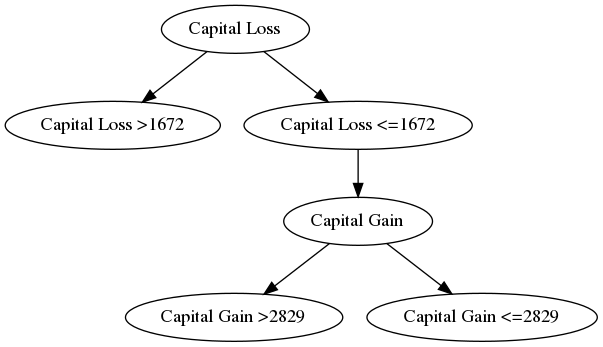

In [32]:
mostra_tree_graph(tree2)

In [33]:
Markdown("## Comp. tempos (tamanhos): {:.4f} ({:.4f}) <br/><br/> ".format(elapsed_time2 / elapsed_time1, n_samples/len(train_data)))

## Comp. tempos (tamanhos): 0.0042 (0.0017) <br/><br/> 

In [34]:
temp = test_step_prob(train_batch,tree)
temp2 = test_step_prob(test_batch,tree)

In [35]:
Markdown("## Base de treino, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp[0], temp[1]))

## Base de treino, precisão: 0.5000, média das probabilidades 0.7630

In [36]:
Markdown("## Base de teste, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp2[0], temp2[1]))

## Base de teste, precisão: 0.5200, média das probabilidades 0.7731

In [37]:
mostra_tree(tree2)
mostra_tree(tree)

Capital Loss
├── Capital Loss >1672: >50K (1.0)
└── Capital Loss <=1672
    └── Capital Gain
        ├── Capital Gain >2829: >50K (1.0)
        └── Capital Gain <=2829: <=50K (0.6097560975609756)
Capital Loss
├── Capital Loss >155
│   └── Relationship
│       ├── Husband
│       │   └── Education
│       │       ├── 10th
│       │       │   └── Hours per week
│       │       │       ├── Hours per week >47: <=50K (1.0)
│       │       │       └── Hours per week <=47: >50K (0.8571428571428571)
│       │       ├── 11th
│       │       │   └── Hours per week
│       │       │       ├── Hours per week >40: >50K (0.6666666666666666)
│       │       │       └── Hours per week <=40: <=50K (0.8)
│       │       ├── 12th
│       │       │   └── Capital Loss >155
│       │       │       ├── Capital Loss >155 >1651: >50K (1.0)
│       │       │       └── Capital Loss >155 <=1651: <=50K (1.0)
│       │       ├── 1st-4th: <=50K (1.0)
│       │       ├── 5th-6th: <=50K (0.8571428571428571)
│       │ 

# Mais ramificações.

In [38]:
t = time.process_time()
tree =  buildtree(train_data,T_pro=0.95, T_pro_num=0.8,total_splits=100)
elapsed_time3 = time.process_time() - t
Markdown("## Tempo (s): {:.2f} <br/><br/> ".format(elapsed_time3))

## Tempo (s): 871.06 <br/><br/> 

In [39]:
 mostra_tree(tree)

Capital Loss
├── Capital Loss >155
│   └── Relationship
│       ├── Husband
│       │   └── Education
│       │       ├── 10th
│       │       │   └── Hours per week
│       │       │       ├── Hours per week >47: <=50K (1.0)
│       │       │       └── Hours per week <=47: >50K (0.8571428571428571)
│       │       ├── 11th
│       │       │   └── Hours per week
│       │       │       ├── Hours per week >40: >50K (0.6666666666666666)
│       │       │       └── Hours per week <=40: <=50K (0.8)
│       │       ├── 12th
│       │       │   └── Capital Loss >155
│       │       │       ├── Capital Loss >155 >1651: >50K (1.0)
│       │       │       └── Capital Loss >155 <=1651: <=50K (1.0)
│       │       ├── 1st-4th: <=50K (1.0)
│       │       ├── 5th-6th: <=50K (0.8571428571428571)
│       │       ├── 7th-8th: <=50K (0.9166666666666666)
│       │       ├── 9th: <=50K (0.6666666666666666)
│       │       ├── Assoc-acdm: >50K (0.6428571428571429)
│       │       ├── Assoc-voc: >50K (0.5

# Volte para a apresentação!

# Combinando as árvores:

In [40]:
n_samples=50
forest = list()
M = 10
for m in range(0,M):
    print(str(m+1)+'/'+str(M), end='\r')
    train_bag = amostra_dados(train_data,n_samples)    
    forest.append(buildtree(train_bag))

In [41]:
mostra_tree(forest[0])

Capital Loss
├── Capital Loss >1721: >50K (1.0)
└── Capital Loss <=1721
    └── Capital Gain
        ├── Capital Gain >3103: >50K (0.875)
        └── Capital Gain <=3103: <=50K (0.6)


In [42]:
mostra_tree(forest[1])

Capital Gain
├── Capital Gain >2354: >50K (0.75)
└── Capital Gain <=2354
    └── Relationship
        ├── Husband
        │   └── Education
        │       ├── 10th: >50K (1.0)
        │       ├── 7th-8th: <=50K (1.0)
        │       ├── 9th: <=50K (1.0)
        │       ├── Assoc-voc: >50K (1.0)
        │       ├── Bachelors: >50K (1.0)
        │       ├── HS-grad: >50K (0.8)
        │       ├── Masters: >50K (1.0)
        │       └── Some-college: >50K (0.6)
        ├── Not-in-family
        │   └── Education
        │       ├── Assoc-acdm: <=50K (1.0)
        │       ├── Bachelors: <=50K (1.0)
        │       ├── Doctorate: >50K (1.0)
        │       ├── Masters: <=50K (1.0)
        │       └── Prof-school: >50K (1.0)
        ├── Other-relative: <=50K (1.0)
        ├── Own-child: <=50K (1.0)
        ├── Unmarried: <=50K (1.0)
        └── Wife: >50K (0.6666666666666666)


In [43]:
mostra_tree(forest[2])

Capital Loss
├── Capital Loss >2547: >50K (1.0)
└── Capital Loss <=2547
    └── Capital Gain
        ├── Capital Gain >3103: >50K (1.0)
        └── Capital Gain <=3103
            └── Marital Status
                ├── Divorced
                │   └── Sex
                │       ├── Female: <=50K (1.0)
                │       └── Male: >50K (1.0)
                ├── Married-civ-spouse
                │   └── Occupation
                │       ├── Adm-clerical: >50K (1.0)
                │       ├── Craft-repair: >50K (1.0)
                │       ├── Exec-managerial: >50K (0.75)
                │       ├── Machine-op-inspct: >50K (0.6666666666666666)
                │       ├── Other-service: <=50K (1.0)
                │       ├── Prof-specialty: >50K (0.75)
                │       ├── Sales: >50K (1.0)
                │       └── Transport-moving: <=50K (1.0)
                ├── Never-married: <=50K (1.0)
                ├── Separated: <=50K (1.0)
                └── Widowed: <=50K (

## Funções para predição com a floresta.

In [44]:
def predict_forest(arg,forest):
    prob_yes = 0
    prob_no = 0
    count_yes = 0
    count_no = 0    
    for tree in forest:
        result = predict(arg,tree)
        if (result[0] == arg[Target]):
            prob_yes += result[1]
            count_yes += 1
        else:
            prob_no += result[1]
            count_no += 1
    return prob_yes, prob_no, prob_yes / max(count_yes,1), prob_no / max(count_no,1)

def test_step_forest(arg,forest):
    sum_prop = 0;
    count_prop = 0;
    YES = 0
    for i in range(0,len(arg)):
        result = predict_forest(arg.loc[i],forest)
        if result[0]>result[1]:
            YES += 1
            count_prop += 1
            sum_prop += result[2]
    YES = YES / len(arg)
    sum_prop = sum_prop / count_prop
    #print("YES: "+str(YES)+'. NO: '+str(NO)+'.')
    return YES,sum_prop

In [45]:
temp = predict_forest(train_data.loc[0],forest)
Markdown("## Soma das probabilidades (média) <br/><br/> Certo: {:.4f} ({:.4f}), Errado {:.4f} ({:.4f})".format(temp[0], temp[2], temp[1], temp[3]))

## Soma das probabilidades (média) <br/><br/> Certo: 9.2000 (0.9200), Errado 0.0000 (0.0000)

In [46]:
temp = test_step_forest(train_data,forest)
temp2 = test_step_forest(test_data,forest)

In [47]:
Markdown("## Base de treino, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp[0], temp[1]))

## Base de treino, precisão: 0.7801, média das probabilidades 0.8415

In [48]:
Markdown("## Base de teste, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp2[0], temp2[1]))

## Base de teste, precisão: 0.7764, média das probabilidades 0.8412

# Seleção aleatória de $ features $

# (RFS: Random Feature Selection).

In [49]:
def find_winner(df,rfs_par=False):
    if not rfs_par:
        IG = []
        vk = list()
        for key in df.columns.difference([Target]):
            temp,temp2 = find_entropy_attribute(df,key)
            vk.append(temp2)
            IG.append(find_entropy(df)-temp)
        return df.columns.difference([Target])[np.argmax(IG)], vk[np.argmax(IG)]
    else:
        key = df.columns.difference([Target])[np.random.randint(len(df.columns.difference([Target]))-1)]
        temp,vk = find_entropy_attribute(df,key)
        return key, vk
    
def buildtree(df,tree=None, mytree=None, T_pro=0.9, T_pro_num=0.6,total_splits=10,splits=1,rfs=False):
    
    def ramificatree(Thd,ss):
        if (len(clValue)==1):
            tree[node][value] = {}
            tree[node][value]['Class'] = clValue[0]
            tree[node][value]['Prob'] = 1.0
            #print_result_node(node,value,clValue[0],1)
        else:
            prob = counts.max() / counts.sum()
            if (prob>=Thd)or(splits>=total_splits):
                tree[node][value] = {}
                tree[node][value]['Class'] = clValue[counts.argmax()]
                tree[node][value]['Prob'] = prob
                #print_result_node(node,value,clValue[counts.argmax()],prob)
            else:
                ss += 1
                tree[node][value] = buildtree(subtable,splits=ss)
                #print(node +' : '+value+' : *')

    #print(find_winner(df))
    #formata_dados(dados)
    node,vk = find_winner(df,rfs_par=rfs)

    if tree is None:
        tree={}
        tree[node] = {}

    if vk is None:
        attValue = np.unique(df[node])
        for value in attValue:

            subtable = df[df[node] == value].reset_index(drop=True)
            clValue,counts = np.unique(subtable[Target],return_counts=True)

            splits += 1
            ramificatree(T_pro,ss=splits)
    else:
        
        if (len(df[node][df[node] <= vk].unique())>0) and (len(df[node][df[node] > vk].unique())>0):
           
            # >vk
            value = node+' >'+str(vk)
            subtable = df[df[node] > vk].rename(columns = {node:value}).reset_index(drop=True)
            clValue,counts = np.unique(subtable[Target],return_counts=True)            
            if (len(subtable[value].unique())==1) and (len(clValue)>1):
                tree[node][value] = {}
                tree[node][value]['Class'] = clValue[counts.argmax()]
                prob = counts.max() / counts.sum()
                tree[node][value]['Prob'] = prob
                #print_result_node(node,value,clValue[counts.argmax()],prob)
            else:
                splits += 1
                ramificatree(T_pro_num,ss=splits)
            clValue_antes = clValue[0]
            value_antes = value
            # <=vk
            value = node+' <='+str(vk)
            subtable = df[df[node] <= vk].rename(columns = {node:value}).reset_index(drop=True)
            clValue,counts = np.unique(subtable[Target],return_counts=True)
            if ((len(subtable[value].unique())==1) and (len(clValue)>1)):
                tree[node][value] = {}
                tree[node][value]['Class'] = clValue[counts.argmax()]
                prob = counts.max() / counts.sum()
                tree[node][value]['Prob'] = prob
                #print_result_node(node,value,clValue[counts.argmax()],prob)
            else:
                splits += 1
                ramificatree(T_pro_num,ss=splits)

        else:
            df[node] = df[node].astype(str)
            buildtree(df)
        
    return tree


In [50]:
n_samples=50
forest = list()
M = 10
for m in range(0,M):
    print(str(m+1)+'/'+str(M), end='\r')
    train_bag = amostra_dados(train_data,n_samples)    
    forest_rfs.append(buildtree(train_bag,rfs=True))

NameError: name 'forest_rfs' is not defined

In [ ]:
temp = test_step_forest(train_data,forest_rfs)
temp2 = test_step_forest(test_data,forest_rfs)

In [ ]:
Markdown("## Base de treino, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp[0], temp[1]))

In [ ]:
Markdown("## Base de teste, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp2[0], temp2[1]))

# As árvores são diferentes?

In [ ]:
mostra_tree(forest[1])

In [ ]:
mostra_tree(forest[0])

In [ ]:
mostra_tree(forest[3])

In [ ]:
mostra_tree(forest[5])

In [ ]:
size_tree = np.empty((M,1))
m=0
for tree in forest:
    size_tree[m] = len(str(tree))
    m+=1

In [ ]:
mostra_tree(forest[size_tree.argmin()])

In [ ]:
mostra_tree(forest[size_tree.argmax()])

# Com RFS foi pior. Como melhorar?

In [ ]:
n_samples=40
forest = list()
forest_rfs = list()
M = 100
for m in range(0,M):
    print(str(m+1)+'/'+str(M), end='\r')
    train_bag = amostra_dados(train_data,n_samples)    
    forest.append(buildtree(train_bag,T_pro=0.8, T_pro_num=0.8))
    forest_rfs.append(buildtree(train_bag,T_pro=0.8, T_pro_num=0.8, rfs=True))
temp = test_step_forest(train_data,forest)
temp2 = test_step_forest(test_data,forest)

In [ ]:
Markdown("## Base de teste, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp2[0], temp2[1]))

In [ ]:
Markdown("## Base de treino, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp[0], temp[1]))

In [ ]:
temp = test_step_forest(train_data,forest_rfs)
temp2 = test_step_forest(test_data,forest_rfs)

In [ ]:
Markdown("## Base de teste, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp2[0], temp2[1]))

In [ ]:
Markdown("## Base de treino, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp[0], temp[1]))

In [ ]:
n_samples=100
forest = list()
forest_rfs = list()
M = 100
for m in range(0,M):
    print(str(m+1)+'/'+str(M), end='\r')
    train_bag = amostra_dados(train_data,n_samples)    
    forest.append(buildtree(train_bag,T_pro=0.8, T_pro_num=0.8))
    forest_rfs.append(buildtree(train_bag,T_pro=0.8, T_pro_num=0.8, rfs=True))
temp = test_step_forest(train_data,forest)
temp2 = test_step_forest(test_data,forest)

In [ ]:
Markdown("## Base de teste, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp2[0], temp2[1]))

In [ ]:
Markdown("## Base de treino, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp[0], temp[1]))

In [ ]:
temp = test_step_forest(train_data,forest_rfs)
temp2 = test_step_forest(test_data,forest_rfs)

In [ ]:
Markdown("## Base de teste, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp2[0], temp2[1]))

In [ ]:
Markdown("## Base de treino, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp[0], temp[1]))

In [ ]:
n_samples=100
forest = list()
forest_rfs = list()
M = 200
for m in range(0,M):
    print(str(m+1)+'/'+str(M), end='\r')
    train_bag = amostra_dados(train_data,n_samples)    
    forest.append(buildtree(train_bag,T_pro=0.8, T_pro_num=0.8))
    forest_rfs.append(buildtree(train_bag,T_pro=0.8, T_pro_num=0.8, rfs=True))
temp = test_step_forest(train_data,forest)
temp2 = test_step_forest(test_data,forest)

In [ ]:
Markdown("## Base de teste, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp2[0], temp2[1]))

In [ ]:
Markdown("## Base de treino, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp[0], temp[1]))

In [ ]:
temp = test_step_forest(train_data,forest_rfs)
temp2 = test_step_forest(test_data,forest_rfs)

In [ ]:
Markdown("## Base de teste, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp2[0], temp2[1]))

In [ ]:
Markdown("## Base de treino, precisão: {:.4f}, média das probabilidades {:.4f}".format(temp[0], temp[1]))

# Fim